In [1]:
import numpy as np
import pandas as pd
import transformers
import torch

from tqdm import tqdm, trange
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f'There are {torch.cuda.device_count()} GPU(s) available.')
print('Device name:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
benign_data = pd.read_csv("/content/drive/MyDrive/Thesis_Projects/URL_detection/Benign.csv")

malicious_data = pd.read_csv("/content/drive/MyDrive/Thesis_Projects/URL_detection/Malicious.csv")

df1 = pd.DataFrame(benign_data)
df2 = pd.DataFrame(malicious_data)

x = df1.sample(25000)
y = df2.sample(25000)

data = pd.concat([x,y], axis=0)
data = shuffle(data)
data

,url,label
20153,tangletangle.com/wp-content/plugins/zapxfbitet...,1
36412,home.snafu.de/~khz/Knoors/,0
4478,www.mobileshoppee.com/insurance.php,0
11140,datlon.com/images/properties/profiles/LoginSer...,1
2840,pcd406046.netvigator.com/eyeos/auth.html,1
...,...,...
22399,genymears.org/S7XIde/webscr.php?cmd_=session.s...,1
19577,tools.ietf.org/html/rfc2262,0
6227,pastehtml.com/view/b5uabw5h1.html,1
30640,robosavvy.com/forum/,0


In [5]:
sentences = data['url'].values
labels = data['label'].values

In [7]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [10]:
# Tokenize the sentences
input_ids = []
attention_masks = []

max_length = 128  # Adjusted sequence length for better performance

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=max_length,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

<ipython-input-10-204dea677581>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [11]:
# Split the data into 80% training and 20% test set
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels,
                                                                        random_state=2018, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, attention_masks,
                                                 random_state=2018, test_size=0.2)

# Further split the training data into 75% training and 25% validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels,
                                                                                    random_state=2018, test_size=0.25)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks,
                                                       random_state=2018, test_size=0.25)

# Create the DataLoader for training, validation, and test sets
batch_size_train = 32
batch_size_val = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size_train)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size_val)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size_val)


In [12]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 10
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# Early stopping criteria
patience = 2
early_stopping_counter = 0
best_validation_loss = float('inf')

In [17]:
# Training loop
loss_values, validation_loss_values = [], []

for epoch_i in range(0, epochs):
    print(f'Epoch {epoch_i + 1}/{epochs}')
    print('Training...')

    model.train()
    total_loss = 0

    # Shuffle the training data at the beginning of each epoch
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size_train)

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print(f'Average training loss: {avg_train_loss}')

    print('Running Validation...')
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_loss = outputs.loss.item()  # Adjusted this line to correctly access loss
        eval_loss += tmp_eval_loss

        preds_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        eval_accuracy += np.sum(preds_flat == labels_flat) / len(labels_flat)

        nb_eval_steps += 1

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    avg_val_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(avg_val_loss)

    print(f'Validation Accuracy: {avg_val_accuracy}')
    print(f'Validation Loss: {avg_val_loss}')

    # Early stopping
    if avg_val_loss < best_validation_loss:
        best_validation_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping triggered.')
        break

print(f'Training complete!')

Epoch 1/10
Training...
Average training loss: 0.05257665894925967
Running Validation...
Validation Accuracy: 0.9786027070063694
Validation Loss: 0.0930524674614233
Epoch 2/10
Training...
Average training loss: 0.02641535477216248
Running Validation...
Validation Accuracy: 0.9799960191082803
Validation Loss: 0.0983027580355822
Epoch 3/10
Training...
Average training loss: 0.014373618869809155
Running Validation...
Validation Accuracy: 0.980593152866242
Validation Loss: 0.12584705137596525
Early stopping triggered.
Training complete!


              precision    recall  f1-score   support

           0     0.9669    0.9911    0.9788      5063
           1     0.9906    0.9652    0.9777      4937

    accuracy                         0.9783     10000
   macro avg     0.9788    0.9781    0.9783     10000
weighted avg     0.9786    0.9783    0.9783     10000



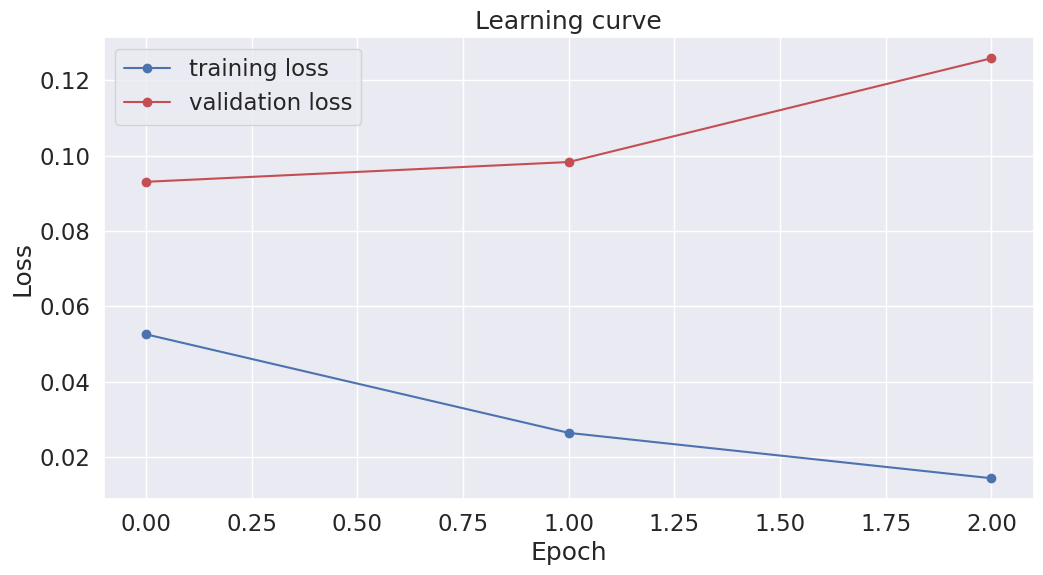

In [18]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on the test set
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Print classification report
print(classification_report(true_labels, predictions, digits=4))

# Plot the learning curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()